# Advanced Lane Finding

## Find perspective

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import settings
import numpy as np
import cv2
import pickle

In [2]:
#images used to find the vanishing point
straight_images = ["test_images/straight_lines1.jpg", "test_images/straight_lines2.jpg"]
roi_points = np.array([[0, settings.ORIGINAL_SIZE[1]-50],[settings.ORIGINAL_SIZE[0],settings.ORIGINAL_SIZE[1]-50],
       [settings.ORIGINAL_SIZE[0]//2,settings.ORIGINAL_SIZE[1]//2+50]], dtype=np.int32)
roi = np.zeros((settings.ORIGINAL_SIZE[1], settings.ORIGINAL_SIZE[0]), dtype=np.uint8)
cv2.fillPoly(roi, [roi_points], 1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [3]:
with open(settings.CALIB_FILE_NAME, 'rb') as f:
    calib_data = pickle.load(f)
    cam_matrix = calib_data["cam_matrix"]
    dist_coeffs = calib_data["dist_coeffs"]


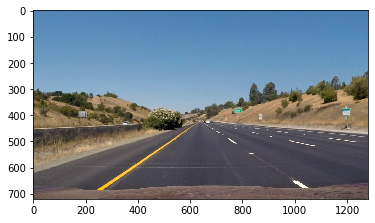

In [5]:

Lhs = np.zeros((2,2), dtype= np.float32)
Rhs = np.zeros((2,1), dtype= np.float32)

img_path = "test_images/straight_lines1.jpg"

img = pimg.imread(img_path)
plt.imshow(img)

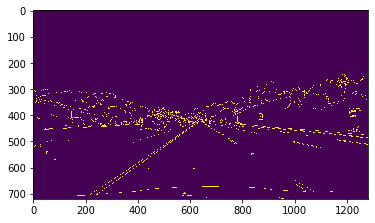

In [6]:
img = cv2.undistort(img, cam_matrix, dist_coeffs)
img_hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
edges = cv2.Canny(img_hsl[:, :, 1], 200, 100)
plt.imshow(edges)

In [8]:
lines = cv2.HoughLinesP(edges*roi, 0.5, np.pi/180, 20, None, 180, 120)
lines

array([[[268, 670, 647, 415]],

       [[288, 670, 652, 415]],

       [[289, 670, 652, 416]],

       [[305, 646, 649, 414]],

       [[267, 670, 643, 417]],

       [[635, 417, 832, 550]],

       [[459, 549, 647, 417]],

       [[293, 666, 644, 420]],

       [[633, 417, 843, 548]],

       [[631, 418, 840, 549]],

       [[632, 417, 843, 549]]], dtype=int32)

In [9]:
for line in lines:
    for x1, y1, x2, y2 in line:
        normal = np.array([[-(y2-y1)], [x2-x1]], dtype=np.float32)
        normal /=np.linalg.norm(normal)
        point = np.array([[x1],[y1]], dtype=np.float32)
        outer = np.matmul(normal, normal.T)
        Lhs += outer
        Rhs += np.matmul(outer, point)
        cv2.line(img, (x1,y1), (x2, y2),(255, 0, 0), thickness=2)

In [11]:
# calculate the vanishing point
vanishing_point = np.matmul(np.linalg.inv(Lhs),Rhs)
vanishing_point

array([[639.8496],
       [421.7243]], dtype=float32)

In [ ]:

Lhs = np.zeros((2,2), dtype= np.float32)
Rhs = np.zeros((2,1), dtype= np.float32)

img_path = "test_images/straight_lines1.jpg"

img = pimg.imread(img_path)
img = cv2.undistort(img, cam_matrix, dist_coeffs)
img_hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
edges = cv2.Canny(img_hsl[:, :, 1], 200, 100)
lines = cv2.HoughLinesP(edges*roi, 0.5, np.pi/180, 20, None, 180, 120)
for line in lines:
    for x1, y1, x2, y2 in line:
        normal = np.array([[-(y2-y1)], [x2-x1]], dtype=np.float32)
        normal /=np.linalg.norm(normal)
        point = np.array([[x1],[y1]], dtype=np.float32)
        outer = np.matmul(normal, normal.T)
        Lhs += outer
        Rhs += np.matmul(outer, point)
        cv2.line(img, (x1,y1), (x2, y2),(255, 0, 0), thickness=2)
# calculate the vanishing point
vanishing_point = np.matmul(np.linalg.inv(Lhs),Rhs)

In [ ]:

Lhs = np.zeros((2,2), dtype= np.float32)
Rhs = np.zeros((2,1), dtype= np.float32)


for img_path in straight_images:
    img = pimg.imread(img_path)
    img = cv2.undistort(img, cam_matrix, dist_coeffs)
    img_hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    edges = cv2.Canny(img_hsl[:, :, 1], 200, 100)
    lines = cv2.HoughLinesP(edges*roi, 0.5, np.pi/180, 20, None, 180, 120)
    for line in lines:
        for x1, y1, x2, y2 in line:
            normal = np.array([[-(y2-y1)], [x2-x1]], dtype=np.float32)
            normal /=np.linalg.norm(normal)
            point = np.array([[x1],[y1]], dtype=np.float32)
            outer = np.matmul(normal, normal.T)
            Lhs += outer
            Rhs += np.matmul(outer, point)
            cv2.line(img, (x1,y1), (x2, y2),(255, 0, 0), thickness=2)
# calculate the vanishing point
vanishing_point = np.matmul(np.linalg.inv(Lhs),Rhs)

In [12]:

top = vanishing_point[1] + 60
bottom = settings.ORIGINAL_SIZE[1]-35
width = 530
def on_line(p1, p2, ycoord):
    return [p1[0]+ (p2[0]-p1[0])/float(p2[1]-p1[1])*(ycoord-p1[1]), ycoord]


#define source and destination targets
p1 = [vanishing_point[0] - width/2, top]
p2 = [vanishing_point[0] + width/2, top]
p3 = on_line(p2, vanishing_point, bottom)
p4 = on_line(p1, vanishing_point, bottom)
src_points = np.array([p1,p2,p3,p4], dtype=np.float32)
dst_points = np.array([[0, 0], [settings.UNWARPED_SIZE[0], 0],
                       [settings.UNWARPED_SIZE[0], settings.UNWARPED_SIZE[1]],
                       [0, settings.UNWARPED_SIZE[1]]], dtype=np.float32)

print(src_points)
print(dst_points)

[[ 374.8496   481.7243 ]
 [ 904.8496   481.7243 ]
 [1802.6506   685.     ]
 [-522.95135  685.     ]]
[[  0.   0.]
 [500.   0.]
 [500. 600.]
 [  0. 600.]]


In [13]:
# draw the trapezoid

cv2.polylines(img, [src_points.astype(np.int32)],True, (0,0,255), thickness=5)


array([[[ 83, 137, 184],
        [ 83, 137, 184],
        [ 83, 137, 184],
        ...,
        [ 72, 130, 178],
        [ 73, 131, 179],
        [ 74, 132, 180]],

       [[ 84, 136, 184],
        [ 83, 137, 184],
        [ 83, 137, 184],
        ...,
        [ 72, 130, 177],
        [ 73, 131, 178],
        [ 73, 131, 178]],

       [[ 84, 136, 184],
        [ 84, 136, 184],
        [ 84, 136, 184],
        ...,
        [ 73, 131, 177],
        [ 73, 131, 177],
        [ 73, 130, 177]],

       ...,

       [[ 98,  86, 100],
        [ 99,  87, 101],
        [ 99,  86, 100],
        ...,
        [117,  96,  91],
        [117,  96,  91],
        [115,  94,  89]],

       [[102,  89,  99],
        [102,  89,  99],
        [102,  89,  99],
        ...,
        [116,  95,  91],
        [117,  96,  92],
        [115,  94,  90]],

       [[104,  89,  99],
        [104,  89,  99],
        [105,  90, 100],
        ...,
        [115,  95,  94],
        [119,  99,  98],
        [119,  99,  98]]

In [15]:
# https://www.geeksforgeeks.org/python-opencv-cv2-polylines-method/
# Displaying the image 
while(1): 
      
    cv2.imshow('image', img) 
    if cv2.waitKey(20) & 0xFF == 27: 
        break
          
cv2.destroyAllWindows() 

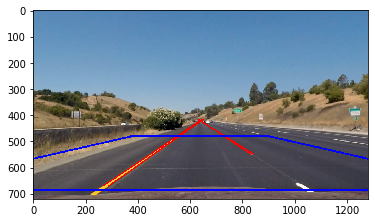

In [16]:
plt.imshow(img)

In [18]:

#find the projection matrix
M = cv2.getPerspectiveTransform(src_points, dst_points)
min_wid = 1000

In [19]:
# img_path in straight_images:
img = pimg.imread(img_path)
img = cv2.undistort(img, cam_matrix, dist_coeffs)
img = cv2.warpPerspective(img, M, settings.UNWARPED_SIZE)
img_hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
mask = img_hsl[:,:,1]>128
mask[:, :50]=0
mask[:, -50:]=0
mom = cv2.moments(mask[:,:settings.UNWARPED_SIZE[0]//2].astype(np.uint8))
x1 = mom["m10"]/mom["m00"]
mom = cv2.moments(mask[:,settings.UNWARPED_SIZE[0]//2:].astype(np.uint8))
x2 = settings.UNWARPED_SIZE[0]//2 + mom["m10"]/mom["m00"]
cv2.line(img, (int(x1), 0), (int(x1), settings.UNWARPED_SIZE[1]), (255, 0, 0), 3)
cv2.line(img, (int(x2), 0), (int(x2), settings.UNWARPED_SIZE[1]), (0, 0, 255), 3)
if (x2-x1<min_wid):
    min_wid = x2-x1

68.35068053921901 48.63266778883803


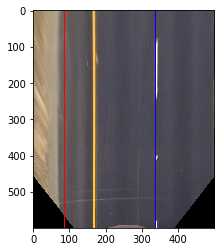

In [20]:

meter_per_foot = 1/3.28084
pix_per_meter_x = min_wid/(12* meter_per_foot)
Lh = np.linalg.inv(np.matmul(M, cam_matrix))
pix_per_meter_y = pix_per_meter_x * np.linalg.norm(Lh[:,0]) / np.linalg.norm(Lh[:,1])
print(pix_per_meter_x, pix_per_meter_y)

plt.imshow(img)
plt.show()

In [ ]:
perspective_data = {'perspective_transform':M,
              'pixels_per_meter':(pix_per_meter_x, pix_per_meter_y),
              'orig_points':src_points}
with open(settings.PERSPECTIVE_FILE_NAME, 'wb') as f:
    pickle.dump(perspective_data, f)


## Find lane

In [23]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import cv2
import os
import numpy as np
import settings
import math
from settings import CALIB_FILE_NAME, PERSPECTIVE_FILE_NAME


In [32]:

def get_center_shift(coeffs, img_size, pixels_per_meter):
    return np.polyval(coeffs, img_size[1]/pixels_per_meter[1]) - (img_size[0]//2)/pixels_per_meter[0]

def get_curvature(coeffs, img_size, pixels_per_meter):
    return ((1 + (2*coeffs[0]*img_size[1]/pixels_per_meter[1] + coeffs[1])**2)**1.5) / np.absolute(2*coeffs[0])


#class that finds line in a mask
class LaneLineFinder:
    def __init__(self, img_size, pixels_per_meter, center_shift):
        self.found = False
        self.poly_coeffs = np.zeros(3, dtype=np.float32)
        self.coeff_history = np.zeros((3, 7), dtype=np.float32)
        self.img_size = img_size
        self.pixels_per_meter = pixels_per_meter
        self.line_mask = np.ones((img_size[1], img_size[0]), dtype=np.uint8)
        self.other_line_mask = np.zeros_like(self.line_mask)
        self.line = np.zeros_like(self.line_mask)
        self.num_lost = 0
        self.still_to_find = 1
        self.shift = center_shift
        self.first = True
        self.stddev = 0
        
    def reset_lane_line(self):
        self.found = False
        self.poly_coeffs = np.zeros(3, dtype=np.float32)
        self.line_mask[:] = 1
        self.first = True

    def one_lost(self):
        self.still_to_find = 5
        if self.found:
            self.num_lost += 1
            if self.num_lost >= 7:
                self.reset_lane_line()

    def one_found(self):
        self.first = False
        self.num_lost = 0
        if not self.found:
            self.still_to_find -= 1
            if self.still_to_find <= 0:
                self.found = True

    def fit_lane_line(self, mask):
        y_coord, x_coord = np.where(mask)
        y_coord = y_coord.astype(np.float32)/self.pixels_per_meter[1]
        x_coord = x_coord.astype(np.float32)/self.pixels_per_meter[0]
        if len(y_coord) <= 150:
            coeffs = np.array([0, 0, (self.img_size[0]//2)/self.pixels_per_meter[0] + self.shift], dtype=np.float32)
        else:
            coeffs, v = np.polyfit(y_coord, x_coord, 2, rcond=1e-16, cov=True)
            self.stddev = 1 - math.exp(-5*np.sqrt(np.trace(v)))

        self.coeff_history = np.roll(self.coeff_history, 1)

        if self.first:
            self.coeff_history = np.reshape(np.repeat(coeffs, 7), (3, 7))
        else:
            self.coeff_history[:, 0] = coeffs

        value_x = get_center_shift(coeffs, self.img_size, self.pixels_per_meter)
        curve = get_curvature(coeffs, self.img_size, self.pixels_per_meter)

        print(value_x - self.shift)
        if (self.stddev > 0.95) | (len(y_coord) < 150) | (math.fabs(value_x - self.shift) > math.fabs(0.5*self.shift)) \
                | (curve < 30):

            self.coeff_history[0:2, 0] = 0
            self.coeff_history[2, 0] = (self.img_size[0]//2)/self.pixels_per_meter[0] + self.shift
            self.one_lost()
            print(self.stddev, len(y_coord), math.fabs(value_x-self.shift)-math.fabs(0.5*self.shift), curve)
        else:
            self.one_found()

        self.poly_coeffs = np.mean(self.coeff_history, axis=1)

    def get_line_points(self):
        y = np.array(range(0, self.img_size[1]+1, 10), dtype=np.float32)/self.pixels_per_meter[1]
        x = np.polyval(self.poly_coeffs, y)*self.pixels_per_meter[0]
        y *= self.pixels_per_meter[1]
        return np.array([x, y], dtype=np.int32).T

    def get_other_line_points(self):
        pts = self.get_line_points()
        pts[:, 0] = pts[:, 0] - 2*self.shift*self.pixels_per_meter[0]
        return pts

    def find_lane_line(self, mask, reset=False):
        n_segments = 16
        window_width = 30
        step = self.img_size[1]//n_segments

        if reset or (not self.found and self.still_to_find == 5) or self.first:
            self.line_mask[:] = 0
            n_steps = 4
            window_start = self.img_size[0]//2 + int(self.shift*self.pixels_per_meter[0]) - 3 * window_width
            window_end = window_start + 6*window_width
            sm = np.sum(mask[self.img_size[1]-4*step:self.img_size[1], window_start:window_end], axis=0)
            sm = np.convolve(sm, np.ones((window_width,))/window_width, mode='same')
            argmax = window_start + np.argmax(sm)
            shift = 0
            for last in range(self.img_size[1], 0, -step):
                first_line = max(0, last - n_steps*step)
                sm = np.sum(mask[first_line:last, :], axis=0)
                sm = np.convolve(sm, np.ones((window_width,))/window_width, mode='same')
                window_start = min(max(argmax + int(shift)-window_width//2, 0), self.img_size[0]-1)
                window_end = min(max(argmax + int(shift) + window_width//2, 0+1), self.img_size[0])
                new_argmax = window_start + np.argmax(sm[window_start:window_end])
                new_max = np.max(sm[window_start:window_end])
                if new_max <= 2:
                    new_argmax = argmax + int(shift)
                    shift = shift/2
                if last != self.img_size[1]:
                    shift = shift*0.25 + 0.75*(new_argmax - argmax)
                argmax = new_argmax
                cv2.rectangle(self.line_mask, (argmax-window_width//2, last-step), (argmax+window_width//2, last),
                              1, thickness=-1)
        else:
            self.line_mask[:] = 0
            points = self.get_line_points()
            if not self.found:
                factor = 3
            else:
                factor = 2
            cv2.polylines(self.line_mask, [points], 0, 1, thickness=int(factor*window_width))

        self.line = self.line_mask * mask
        self.fit_lane_line(self.line)
        self.first = False
        if not self.found:
            self.line_mask[:] = 1
        points = self.get_other_line_points()
        self.other_line_mask[:] = 0
        cv2.polylines(self.other_line_mask, [points], 0, 1, thickness=int(5*window_width))

# class that finds the whole lane
class LaneFinder:
    def __init__(self, img_size, warped_size, cam_matrix, dist_coeffs, transform_matrix, pixels_per_meter, warning_icon):
        self.found = False
        self.cam_matrix = cam_matrix
        self.dist_coeffs = dist_coeffs
        self.img_size = img_size
        self.warped_size = warped_size
        self.mask = np.zeros((warped_size[1], warped_size[0], 3), dtype=np.uint8)
        self.roi_mask = np.ones((warped_size[1], warped_size[0], 3), dtype=np.uint8)
        self.total_mask = np.zeros_like(self.roi_mask)
        self.warped_mask = np.zeros((self.warped_size[1], self.warped_size[0]), dtype=np.uint8)
        self.M = transform_matrix
        self.count = 0
        self.left_line = LaneLineFinder(warped_size, pixels_per_meter, -1.8288)  # 6 feet in meters
        self.right_line = LaneLineFinder(warped_size, pixels_per_meter, 1.8288)
        if (warning_icon is not None):
            self.warning_icon=np.array(mpimg.imread(warning_icon)*255, dtype=np.uint8)
        else:
            self.warning_icon=None

    def undistort(self, img):
        return cv2.undistort(img, self.cam_matrix, self.dist_coeffs)

    def warp(self, img):
        return cv2.warpPerspective(img, self.M, self.warped_size, flags=cv2.WARP_FILL_OUTLIERS+cv2.INTER_CUBIC)

    def unwarp(self, img):
        return cv2.warpPerspective(img, self.M, self.img_size, flags=cv2.WARP_FILL_OUTLIERS +
                                                                     cv2.INTER_CUBIC+cv2.WARP_INVERSE_MAP)

    def equalize_lines(self, alpha=0.9):
        mean = 0.5 * (self.left_line.coeff_history[:, 0] + self.right_line.coeff_history[:, 0])
        self.left_line.coeff_history[:, 0] = alpha * self.left_line.coeff_history[:, 0] + \
                                             (1-alpha)*(mean - np.array([0,0, 1.8288], dtype=np.uint8))
        self.right_line.coeff_history[:, 0] = alpha * self.right_line.coeff_history[:, 0] + \
                                              (1-alpha)*(mean + np.array([0,0, 1.8288], dtype=np.uint8))

    def find_lane(self, img, distorted=True, reset=False):
        # undistort, warp, change space, filter
        if distorted:
            img = self.undistort(img)
        if reset:
            self.left_line.reset_lane_line()
            self.right_line.reset_lane_line()

        img = self.warp(img)
        img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        img_hls = cv2.medianBlur(img_hls, 5)
        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        img_lab = cv2.medianBlur(img_lab, 5)

        big_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31, 31))
        small_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))

        greenery = (img_lab[:, :, 2].astype(np.uint8) > 130) & cv2.inRange(img_hls, (0, 0, 50), (35, 190, 255))

        road_mask = np.logical_not(greenery).astype(np.uint8) & (img_hls[:, :, 1] < 250)
        road_mask = cv2.morphologyEx(road_mask, cv2.MORPH_OPEN, small_kernel)
        road_mask = cv2.dilate(road_mask, big_kernel)

        img2, contours = cv2.findContours(road_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

        biggest_area = 0
        for contour in contours:
            area = cv2.contourArea(contour)
            if area>biggest_area:
                biggest_area = area
                biggest_contour = contour
        road_mask = np.zeros_like(road_mask)
        cv2.fillPoly(road_mask, [biggest_contour],  1)

        self.roi_mask[:, :, 0] = (self.left_line.line_mask | self.right_line.line_mask) & road_mask
        self.roi_mask[:, :, 1] = self.roi_mask[:, :, 0]
        self.roi_mask[:, :, 2] = self.roi_mask[:, :, 0]

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 3))
        black = cv2.morphologyEx(img_lab[:,:, 0], cv2.MORPH_TOPHAT, kernel)
        lanes = cv2.morphologyEx(img_hls[:,:,1], cv2.MORPH_TOPHAT, kernel)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13))
        lanes_yellow = cv2.morphologyEx(img_lab[:, :, 2], cv2.MORPH_TOPHAT, kernel)

        self.mask[:, :, 0] = cv2.adaptiveThreshold(black, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 13, -6)
        self.mask[:, :, 1] = cv2.adaptiveThreshold(lanes, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 13, -4)
        self.mask[:, :, 2] = cv2.adaptiveThreshold(lanes_yellow, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,
                                                   13, -1.5)
        self.mask *= self.roi_mask
        small_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        self.total_mask = np.any(self.mask, axis=2).astype(np.uint8)
        self.total_mask = cv2.morphologyEx(self.total_mask.astype(np.uint8), cv2.MORPH_ERODE, small_kernel)

        left_mask = np.copy(self.total_mask)
        right_mask = np.copy(self.total_mask)
        if self.right_line.found:
            left_mask = left_mask & np.logical_not(self.right_line.line_mask) & self.right_line.other_line_mask
        if self.left_line.found:
            right_mask = right_mask & np.logical_not(self.left_line.line_mask) & self.left_line.other_line_mask
        self.left_line.find_lane_line(left_mask, reset)
        self.right_line.find_lane_line(right_mask, reset)
        self.found = self.left_line.found and self.right_line.found

        if self.found:
            self.equalize_lines(0.875)

    def draw_lane_weighted(self, img, thickness=5, alpha=0.8, beta=1, gamma=0):
        left_line = self.left_line.get_line_points()
        right_line = self.right_line.get_line_points()
        both_lines = np.concatenate((left_line, np.flipud(right_line)), axis=0)
        lanes = np.zeros((self.warped_size[1], self.warped_size[0], 3), dtype=np.uint8)
        if self.found:
            cv2.fillPoly(lanes, [both_lines.astype(np.int32)], (0, 255, 0))
            cv2.polylines(lanes, [left_line.astype(np.int32)], False, (255, 0, 0),thickness=5 )
            cv2.polylines(lanes, [right_line.astype(np.int32)],False,  (0, 0, 255), thickness=5)
            cv2.fillPoly(lanes, [both_lines.astype(np.int32)], (0, 255, 0))
            mid_coef = 0.5 * (self.left_line.poly_coeffs + self.right_line.poly_coeffs)
            curve = get_curvature(mid_coef, img_size=self.warped_size, pixels_per_meter=self.left_line.pixels_per_meter)
            shift = get_center_shift(mid_coef, img_size=self.warped_size,
                                     pixels_per_meter=self.left_line.pixels_per_meter)
            cv2.putText(img, "Road curvature: {:6.2f}m".format(curve), (420, 50), cv2.FONT_HERSHEY_PLAIN, fontScale=2.5,
                        thickness=5, color=(255, 255, 255))
            cv2.putText(img, "Road curvature: {:6.2f}m".format(curve), (420, 50), cv2.FONT_HERSHEY_PLAIN, fontScale=2.5,
                        thickness=3, color=(0, 0, 0))
            cv2.putText(img, "Car position: {:4.2f}m".format(shift), (460, 100), cv2.FONT_HERSHEY_PLAIN, fontScale=2.5,
                        thickness=5, color=(255, 255, 255))
            cv2.putText(img, "Car position: {:4.2f}m".format(shift), (460, 100), cv2.FONT_HERSHEY_PLAIN, fontScale=2.5,
                        thickness=3, color=(0, 0, 0))
        else:
            warning_shape = self.warning_icon.shape
            corner = (10, (img.shape[1]-warning_shape[1])//2)
            patch = img[corner[0]:corner[0]+warning_shape[0], corner[1]:corner[1]+warning_shape[1]]
            patch[self.warning_icon[:, :, 3] > 0] = self.warning_icon[self.warning_icon[:, :, 3] > 0, 0:3]
            img[corner[0]:corner[0]+warning_shape[0], corner[1]:corner[1]+warning_shape[1]]=patch
            cv2.putText(img, "Lane lost!", (550, 170), cv2.FONT_HERSHEY_PLAIN, fontScale=2.5,
                        thickness=5, color=(255, 255, 255))
            cv2.putText(img, "Lane lost!", (550, 170), cv2.FONT_HERSHEY_PLAIN, fontScale=2.5,
                        thickness=3, color=(0, 0, 0))
        lanes_unwarped = self.unwarp(lanes)
        return cv2.addWeighted(img, alpha, lanes_unwarped, beta, gamma)

    def process_image(self, img, reset=False, show_period=10, blocking=False):
        self.find_lane(img, reset=reset)
        lane_img = self.draw_lane_weighted(img)
        self.count += 1
        if show_period > 0 and (self.count % show_period == 1 or show_period == 1):
            start = 231
            plt.clf()
            for i in range(3):
                plt.subplot(start+i)
                plt.imshow(lf.mask[:, :, i]*255,  cmap='gray')
                plt.subplot(234)
            plt.imshow((lf.left_line.line + lf.right_line.line)*255)

            ll = cv2.merge((lf.left_line.line, lf.left_line.line*0, lf.right_line.line))
            lm = cv2.merge((lf.left_line.line_mask, lf.left_line.line*0, lf.right_line.line_mask))
            plt.subplot(235)
            plt.imshow(lf.roi_mask*255,  cmap='gray')
            plt.subplot(236)
            plt.imshow(lane_img)
            if blocking:
                plt.show()
            else:
                plt.draw()
                plt.pause(0.000001)
        return lane_img



In [33]:

with open(CALIB_FILE_NAME, 'rb') as f:
    calib_data = pickle.load(f)
cam_matrix = calib_data["cam_matrix"]
dist_coeffs = calib_data["dist_coeffs"]
img_size = calib_data["img_size"]


with open(PERSPECTIVE_FILE_NAME, 'rb') as f:
    perspective_data = pickle.load(f)

perspective_transform = perspective_data["perspective_transform"]
pixels_per_meter = perspective_data['pixels_per_meter']
orig_points = perspective_data["orig_points"]

input_dir = "test_images"
output_dir = "output_images"


In [34]:
image_files = os.listdir(input_dir)
image_files

['img_0.png',
 'img_1.png',
 'img_10.png',
 'img_41.png',
 'img_42.png',
 'img_48.png',
 'img_9.png',
 'straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

ValueError
not enough values to unpack (expected 3, got 2)

line 210
`img2, contours, hierarchy = cv2.findContours(road_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)`

Removed `hierarchy`

In [35]:
image_file = 'test1.jpg'
# turn images to grayscale and find chessboard corners
img = mpimg.imread(os.path.join(input_dir, image_file))
lf = LaneFinder(settings.ORIGINAL_SIZE, settings.UNWARPED_SIZE, cam_matrix, dist_coeffs,
    perspective_transform, pixels_per_meter, "warning.png")
img = lf.process_image(img, True, show_period=1, blocking=False)
plt.imshow(img)

error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\shapedescr.cpp:315: error: (-215:Assertion failed) npoints >= 0 && (depth == CV_32F || depth == CV_32S) in function 'cv::contourArea'


In [ ]:

for image_file in os.listdir(input_dir):
        if image_file.endswith("jpg"):
            # turn images to grayscale and find chessboard corners
            img = mpimg.imread(os.path.join(input_dir, image_file))
            lf = LaneFinder(settings.ORIGINAL_SIZE, settings.UNWARPED_SIZE, cam_matrix, dist_coeffs,
                perspective_transform, pixels_per_meter, "warning.png")
            img = lf.process_image(img, True, show_period=1, blocking=False)


